<a href="https://colab.research.google.com/github/dvarkless/InnopolisDS/blob/main/homeworks/LSTM_Sentiment_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [264]:
# All the imports!
import tensorflow as tf 
import numpy as np
from tensorflow.keras.preprocessing import sequence
from numpy import array

# Supress deprecation warnings
import logging
logging.getLogger('tensorflow').disabled = True

# Fetch "IMDB Movie Review" data, constraining our reviews to 
# the 10000 most commonly used words
vocab_size = 7500
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)

# Map for readable classnames
class_names = ["Negative", "Positive"]

In [265]:
x_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

## Создать карту для преобразования набора данных IMDB в удобочитаемые обзоры

Обзоры в наборе данных IMDB были закодированы как последовательность целых чисел. К счастью, набор данных также
содержит указатель для преобразования отзывов в удобочитаемую форму.

In [266]:
# Get the word index from the dataset
word_index = tf.keras.datasets.imdb.get_word_index()

# Ensure that "special" words are mapped into human readable terms 
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNKNOWN>"] = 2
word_index["<UNUSED>"] = 3

# Perform reverse word lookup and make it callable
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [267]:
word_index#[:10]


{'fawn': 34704,
 'tsukino': 52009,
 'nunnery': 52010,
 'sonja': 16819,
 'vani': 63954,
 'woods': 1411,
 'spiders': 16118,
 'hanging': 2348,
 'woody': 2292,
 'trawling': 52011,
 "hold's": 52012,
 'comically': 11310,
 'localized': 40833,
 'disobeying': 30571,
 "'royale": 52013,
 "harpo's": 40834,
 'canet': 52014,
 'aileen': 19316,
 'acurately': 52015,
 "diplomat's": 52016,
 'rickman': 25245,
 'arranged': 6749,
 'rumbustious': 52017,
 'familiarness': 52018,
 "spider'": 52019,
 'hahahah': 68807,
 "wood'": 52020,
 'transvestism': 40836,
 "hangin'": 34705,
 'bringing': 2341,
 'seamier': 40837,
 'wooded': 34706,
 'bravora': 52021,
 'grueling': 16820,
 'wooden': 1639,
 'wednesday': 16821,
 "'prix": 52022,
 'altagracia': 34707,
 'circuitry': 52023,
 'crotch': 11588,
 'busybody': 57769,
 "tart'n'tangy": 52024,
 'burgade': 14132,
 'thrace': 52026,
 "tom's": 11041,
 'snuggles': 52028,
 'francesco': 29117,
 'complainers': 52030,
 'templarios': 52128,
 '272': 40838,
 '273': 52031,
 'zaniacs': 52133,

In [268]:
reverse_word_index

{34704: 'fawn',
 52009: 'tsukino',
 52010: 'nunnery',
 16819: 'sonja',
 63954: 'vani',
 1411: 'woods',
 16118: 'spiders',
 2348: 'hanging',
 2292: 'woody',
 52011: 'trawling',
 52012: "hold's",
 11310: 'comically',
 40833: 'localized',
 30571: 'disobeying',
 52013: "'royale",
 40834: "harpo's",
 52014: 'canet',
 19316: 'aileen',
 52015: 'acurately',
 52016: "diplomat's",
 25245: 'rickman',
 6749: 'arranged',
 52017: 'rumbustious',
 52018: 'familiarness',
 52019: "spider'",
 68807: 'hahahah',
 52020: "wood'",
 40836: 'transvestism',
 34705: "hangin'",
 2341: 'bringing',
 40837: 'seamier',
 34706: 'wooded',
 52021: 'bravora',
 16820: 'grueling',
 1639: 'wooden',
 16821: 'wednesday',
 52022: "'prix",
 34707: 'altagracia',
 52023: 'circuitry',
 11588: 'crotch',
 57769: 'busybody',
 52024: "tart'n'tangy",
 14132: 'burgade',
 52026: 'thrace',
 11041: "tom's",
 52028: 'snuggles',
 29117: 'francesco',
 52030: 'complainers',
 52128: 'templarios',
 40838: '272',
 52031: '273',
 52133: 'zaniacs',

## Data Insight




In [269]:
# Concatenate test and training datasets
allreviews = np.concatenate((x_train, x_test), axis=0)

# Review lengths across test and training whole datasets
print("Maximum review length: {}".format(len(max((allreviews), key=len))))
print("Minimum review length: {}".format(len(min((allreviews), key=len))))
result = [len(x) for x in allreviews]
print("Mean review length: {}".format(np.mean(result)))

# Print a review and it's class as stored in the dataset. Replace the number
# to select a different review.
print("")
print("Machine readable Review")
print("  Review Text: " + str(x_train[60]))
print("  Review Sentiment: " + str(y_train[60]))

# Print a review and it's class in human readable format. Replace the number
# to select a different review.
print("")
print("Human Readable Review")
print("  Review Text: " + decode_review(x_train[60]))
print("  Review Sentiment: " + class_names[y_train[60]])

Maximum review length: 2494
Minimum review length: 7
Mean review length: 234.75892

Machine readable Review
  Review Text: [1, 13, 219, 14, 33, 4, 2, 22, 1413, 12, 16, 373, 175, 2711, 1115, 1026, 430, 939, 16, 23, 2444, 25, 43, 697, 89, 12, 16, 170, 8, 130, 262, 19, 32, 4, 665, 7, 4, 2, 322, 5, 4, 1520, 7, 4, 86, 250, 10, 10, 4, 249, 173, 16, 4, 3891, 6, 19, 4, 167, 564, 5, 564, 1325, 36, 805, 8, 216, 638, 17, 2, 21, 25, 100, 376, 507, 4, 2110, 15, 79, 125, 23, 567, 13, 2134, 233, 36, 4852, 2, 5, 81, 1672, 10, 10, 92, 437, 129, 58, 13, 69, 8, 401, 61, 1432, 39, 1286, 46, 7, 12]
  Review Sentiment: 0

Human Readable Review
  Review Text: <START> i saw this at the <UNKNOWN> film festival it was awful every clichéd violent rich boy fantasy was on display you just knew how it was going to end especially with all the shots of the <UNKNOWN> wife and the rape of the first girl br br the worst part was the q a with the director writer and writer producer they tried to come across as <UNKNOWN> 

## Pre-processing Data

Нам нужно убедиться, что наши обзоры имеют одинаковую длину. Это для параметров LSTM.

Некоторые отзывы нужно будет усечь, а другие дополнить.

In [270]:
# The length of reviews
review_length = 250

# Padding / truncated our reviews
x_train = sequence.pad_sequences(x_train, maxlen = review_length,padding='post')
x_test = sequence.pad_sequences(x_test, maxlen = review_length,padding='post')

# Check the size of our datasets. Review data for both test and training should 
# contain 25000 reviews of 500 integers. Class data should contain 25000 values, 
# one for each review. Class values are 0 or 1, indicating a negative 
# or positive review.
print("Shape Training Review Data: " + str(x_train.shape))
print("Shape Training Class Data: " + str(y_train.shape))
print("Shape Test Review Data: " + str(x_test.shape))
print("Shape Test Class Data: " + str(y_test.shape))

# Note padding is added to start of review, not the end
print("")
print("Human Readable Review Text (post padding): " + decode_review(x_train[60]))

Shape Training Review Data: (25000, 250)
Shape Training Class Data: (25000,)
Shape Test Review Data: (25000, 250)
Shape Test Class Data: (25000,)

Human Readable Review Text (post padding): <START> i saw this at the <UNKNOWN> film festival it was awful every clichéd violent rich boy fantasy was on display you just knew how it was going to end especially with all the shots of the <UNKNOWN> wife and the rape of the first girl br br the worst part was the q a with the director writer and writer producer they tried to come across as <UNKNOWN> but you could tell they're the types that get off on violence i bet anything they frequent <UNKNOWN> and do drugs br br don't waste your time i had to keep my boyfriend from walking out of it <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

## Create and build LSTM Recurrent Neural Network

In [271]:
neurons_num = 48
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        units=neurons_num  # 32 LSTM units in this layer
    ))

In [272]:
# Начнем с определения пустого стека. Мы будем использовать его для создания 
# сети, позже по слоям.
model = tf.keras.models.Sequential()

# The Embedding Layer Word2Vec
model.add(
    tf.keras.layers.Embedding(
        input_dim = vocab_size, # The size of our vocabulary 
        output_dim = neurons_num, # Dimensions to which each words shall be mapped
        input_length = review_length # Length of input sequences
    )
)

# Dropout 
model.add(
    tf.keras.layers.Dropout(
        rate=0.25 # Randomly disable 25% of neurons
    )
)

model.add(
    tf.keras.layers.LSTM(
        units=neurons_num # 32 LSTM units in this layer
    )
)

# Add a second dropout layer with the same aim as the first.
model.add(
    tf.keras.layers.Dropout(
        rate=0.25 # Randomly disable 25% of neurons
    )
)

# Все блоки LSTM подключены к одному узлу в Dense слое.
# Функция активации сигмоида определяет выходной сигнал от этого узла - значение от 0 до 1. 
#Ближе к 0 указывает на отрицательный обзор. Ближе к 1 означает положительный отзыв.
model.add(
    tf.keras.layers.Dense(
        units=1, # Single unit
        activation='sigmoid' # Sigmoid activation function (output from 0 to 1)
    )
)

# Compile the model
model.compile(
    loss=tf.keras.losses.binary_crossentropy, # loss function
    optimizer=tf.keras.optimizers.Adam(), # optimiser function
    metrics=['accuracy']) # reporting metric

# Display a summary of the models structure
model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, 250, 48)           360000    
                                                                 
 dropout_66 (Dropout)        (None, 250, 48)           0         
                                                                 
 lstm_56 (LSTM)              (None, 48)                18624     
                                                                 
 dropout_67 (Dropout)        (None, 48)                0         
                                                                 
 dense_33 (Dense)            (None, 1)                 49        
                                                                 
Total params: 378,673
Trainable params: 378,673
Non-trainable params: 0
_________________________________________________________________


## Visualise the Model

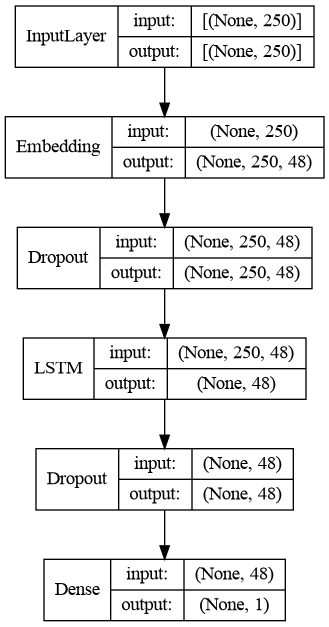

In [273]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

## Train the LSTM

In [274]:
# Train the LSTM on the training data
goal_loss = 0.43
best_loss = 10000
patience = 3
patience_count = patience
for i in range(20):
    print(f"=== On epoch {i+1}/20: ===")
    print('Training:')
    history = model.fit(
        x_train, y_train,                   
        batch_size=128, 
        epochs=1, 
        validation_split=0.2,    
        verbose=1
    ) 
    print('Evaluating:')
    loss, _ = model.evaluate(x_test,y_test)

    if loss > best_loss:
        best_loss *= 1.03
        patience_count -= 1
    else:
        best_loss = loss
        patience_count = patience

    if loss < goal_loss:
        print('Goal reached, stopping now')
        break
    if patience_count <= 0:
        print('It only getting worse, stopping now')
        break


=== On epoch 1/20: ===
Training:
157/157 [==============================] - 28s 166ms/step - loss: 0.6888 - accuracy: 0.5311 - val_loss: 0.6798 - val_accuracy: 0.5598
Evaluating:
782/782 [==============================] - 19s 25ms/step - loss: 0.6797 - accuracy: 0.5614
=== On epoch 2/20: ===
Training:
157/157 [==============================] - 26s 163ms/step - loss: 0.6313 - accuracy: 0.6241 - val_loss: 0.6268 - val_accuracy: 0.6170
Evaluating:
782/782 [==============================] - 19s 24ms/step - loss: 0.6256 - accuracy: 0.6143
=== On epoch 3/20: ===
Training:
157/157 [==============================] - 26s 165ms/step - loss: 0.5741 - accuracy: 0.6804 - val_loss: 0.6534 - val_accuracy: 0.5660
Evaluating:
782/782 [==============================] - 19s 25ms/step - loss: 0.6547 - accuracy: 0.5680
=== On epoch 4/20: ===
Training:
157/157 [==============================] - 26s 164ms/step - loss: 0.6096 - accuracy: 0.6917 - val_loss: 1.1216 - val_accuracy: 0.5076
Evaluating:
782/782 [==

## Evaluate model with test data and view results

In [275]:
model.evaluate(x_test,y_test)

782/782 [==============================] - 19s 24ms/step - loss: 0.4996 - accuracy: 0.7923


[0.4995959401130676, 0.7923200130462646]

In [276]:
# Get Model Predictions for test data
from sklearn.metrics import classification_report
predicted_classes = np.argmax(model.predict(x_test),axis=1)
print(classification_report(y_test, predicted_classes, target_names=class_names, zero_division=1))

782/782 [==============================] - 19s 23ms/step
              precision    recall  f1-score   support

    Negative       0.50      1.00      0.67     12500
    Positive       1.00      0.00      0.00     12500

    accuracy                           0.50     25000
   macro avg       0.75      0.50      0.33     25000
weighted avg       0.75      0.50      0.33     25000



##Выведем несколько примеров некорретных отзывов


In [277]:
predicted_classes_reshaped = np.reshape(predicted_classes, 25000)

incorrect = np.nonzero(predicted_classes_reshaped!=y_test)[0]

# We select the first 10 incorrectly classified reviews
for j, incorrect in enumerate(incorrect[0:20]):
    
    predicted = class_names[predicted_classes_reshaped[incorrect]]
    actual = class_names[y_test[incorrect]]
    human_readable_review = decode_review(x_test[incorrect])
    
    print("Incorrectly classified Test Review ["+ str(j+1) +"]") 
    print("Test Review #" + str(incorrect)  + ": Predicted ["+ predicted + "] Actual ["+ actual + "]")
    print("Test Review Text: " + human_readable_review.replace("<PAD> ", ""))
    print("")

Incorrectly classified Test Review [1]
Test Review #1: Predicted [Negative] Actual [Positive]
Test Review Text: focuses on mood and character development the plot is very simple and many of the scenes take place on the same set in frances <UNKNOWN> the <UNKNOWN> dennis character apartment but the film builds to a disturbing climax br br the characters create an atmosphere <UNKNOWN> with sexual tension and psychological <UNKNOWN> it's very interesting that robert altman directed this considering the style and structure of his other films still the trademark altman audio style is evident here and there i think what really makes this film work is the brilliant performance by <UNKNOWN> dennis it's definitely one of her darker characters but she plays it so perfectly and convincingly that it's scary michael burns does a good job as the mute young man regular altman player michael murphy has a small part the <UNKNOWN> moody set fits the content of the story very well in short this movie is a

## Проверим модель на наших собственных данных



In [292]:
# Write your own review
# review = '<START> actually good and bad in it\'s best way'
# review = '<START> worst bad bad bad bad best'
# review = '<START> good good good good good good but actually the worst'
# review = '<START> '
# review = '<START> it was a cloudy day'
# review = ''
review = "<START> this was a terrible film with too much sex and violence"
# review = "<START> this is the best film i have ever seen it is great and fantastic and i loved it"
# review = "<START> i dont think this movie is bad or good"

# Encode review (replace word with integers)
tmp = []
for word in review.split(" "):
    tmp.append(word_index.get(word, 2))

# Ensure review is 500 words long (by padding or truncating)
tmp_padded = sequence.pad_sequences([tmp], maxlen=review_length,padding='post') 

# Run your processed review against the trained model
rawprediction = model.predict(array([tmp_padded][0]))[0][0]
prediction = int(round(rawprediction))

# Test the model and print the result
print("Review: " + review)
print("Raw Prediction: " + str(rawprediction))
print("Predicted Class: " + class_names[prediction])

1/1 [==============================] - 0s 27ms/step
Review: <START> this was a terrible film with too much sex and violence
Raw Prediction: 0.15707935
Predicted Class: Negative
